In [24]:
from qpe import *
from numpy import log

import qutip as qp
from time import time

from numpy import sign, ceil
from numpy.random import randint

from scipy.stats import unitary_group, gaussian_kde

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rc('text', usetex=True)

In [25]:
def aux_info_iso(pars, n_layers, labels, ps, n_copies=1, n_meas=0, dN=1e-5, n_inp=2):
    """ For the optimized variables theta and x,
    calculates the expectations expecs, their derivatives excepcs_der,
    their variances disps, and quantum and classical Fisher informations """

    if n_meas == 0:
        n_meas = n_tot
    n_tot = max(n_inp*n_copies, n_meas)
    n_dif = n_inp*n_copies - n_meas
    d_diff = 2**max(0, n_dif)
            
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]
    
    ansatz = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    
    projs = [reduce(kron, [diag(line), eye(2**max(0, n_tot - n_meas))]) for line in eye(2**n_meas)]
    projs_u = [ansatz.conj().T@proj@ansatz for proj in projs]

    dm_bell = array([[1, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 1]])/2
    expecs = []
    expecs_der = []
    disps = []
    CFIs = []
    QFIs = []
    for j in range(len(ps)): # take a density matrix from the training set
        p = ps[j]
        N = labels[j]
        if p > 1/3:
            dm_n = (2*N + 1)/3*dm_bell + (1 - N)/6*eye(4)
            dm_n_p = (2*(N + dN) + 1)/3*dm_bell + (1 - (N + dN))/6*eye(4)
            dm_n_m = (2*(N - dN) + 1)/3*dm_bell + (1 - (N - dN))/6*eye(4)
            
            dm_n = reduce(kron, [dm_n]*n_copies + [P0]*(n_meas - n_inp*n_copies))
            dm_n_p = reduce(kron, [dm_n_p]*n_copies + [P0]*(n_meas - n_inp*n_copies))
            dm_n_m = reduce(kron, [dm_n_m]*n_copies + [P0]*(n_meas - n_inp*n_copies))
            
            probs = [trace(dm_n@proj).real for proj in projs_u]
            probs_der = [trace((dm_n_p - dm_n_m)@proj).real/(2*dN) for proj in projs_u]
            
            expec = sum([out_i*prob_i for out_i, prob_i in zip(pars_est, probs)])
            expec_der = sum([out*prob_der for out, prob_der in zip(pars_est, probs_der)])
            disp = sum([out_i**2*prob_i for out_i, prob_i in zip(pars_est, probs)]) - expec**2
            
            CFI = sum([prob_der**2/prob if prob > 0 else 0 for prob_der, prob in zip(probs_der, probs)]) + 1e-10
            QFI = 2*(1 - sqrt(fidelity(dm_n_m, dm_n_p))) / dN**2 + 1e-10 # via centered differences 
            
            expecs.append(expec)
            expecs_der.append(expec_der)
            disps.append(disp)
            CFIs.append(CFI)
            QFIs.append(QFI)
            
        else:
            dm_n = p*dm_bell + (1 - p)/4*eye(4)
            dm_n = reduce(kron, [dm_n]*n_copies + [P0]*(n_meas - n_inp*n_copies))
            
            probs = [trace(dm_n@proj).real for proj in projs_u]
            probs_der = [0 for proj in projs_u]
            
            expec = sum([out_i*prob_i for out_i, prob_i in zip(pars_est, probs)])
            expec_der = sum([out*prob_der for out, prob_der in zip(pars_est, probs_der)])
            
            disp = sum([out_i**2*prob_i for out_i, prob_i in zip(pars_est, probs)]) - expec**2
            CFI = n_copies # placeholder; excluded from the plot
            QFI = n_copies # placeholder; excluded from the plot
            
            expecs.append(expec)
            expecs_der.append(expec_der)
            disps.append(disp)
            CFIs.append(CFI)
            QFIs.append(QFI)
    
    return array(expecs), array(expecs_der), array(disps), array(CFIs), array(QFIs)

# Multiple copies

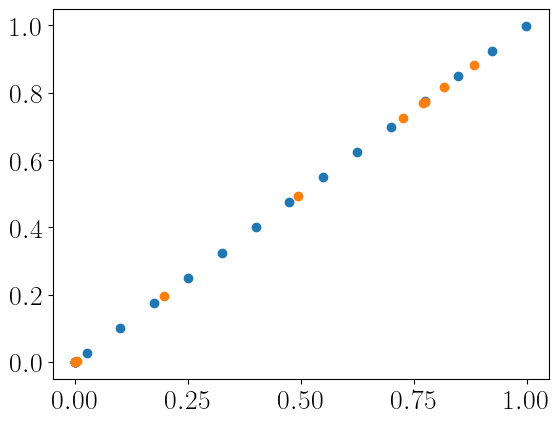

In [26]:
n_inp = 2
n_train = 10
n_test = 21
marks = "neg"

dm_bell = array([[1, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 1]])/2

ps_train = uniform(1e-3, 1 - 1e-3, n_train)
ps_train = array([0.92142164, 0.81713047, 0.11472737, 0.84904261, 0.84647288,
       0.46404783, 0.66170302, 0.03636958, 0.87804348, 0.33567775])
dms_train = [p*dm_bell + (1 - p)/4*eye(4) for p in ps_train]
labels_train = [two_subsys_negativity(dm) for dm in dms_train]

ps_test = linspace(1e-3, 1 - 1e-3, n_test)
dms_test = [p*dm_bell + (1 - p)/4*eye(4) for p in ps_test]
labels_test = [two_subsys_negativity(dm) for dm in dms_test]

dN = 1e-5
dms_check = []
QFIs = []
for N in labels_train:
    dm =   (2*N + 1)/3*dm_bell + (1 - N)/6*eye(4)
    dm_p = (2*(N + dN) + 1)/3*dm_bell + (1 - (N + dN))/6*eye(4)
    dm_m = (2*(N - dN) + 1)/3*dm_bell + (1 - (N - dN))/6*eye(4)
    QFI = 2*(1 - sqrt(fidelity(dm_m, dm_p))) / dN**2 + 1e-10 # via centered differences
    QFIs.append(QFI)
    dms_check.append(dm)

plt.scatter(labels_test, labels_test)
plt.scatter(labels_train, labels_train)

In [27]:
w_ls = 1e0
w_var = 1e-4
dN = 1e-5
method = "BFGS"
options = {"maxiter": int(3e3), "maxfun": int(1e10)}##

### 1 copy

In [28]:
n_copies_1 = 1
n_meas_1 = n_inp*n_copies_1
n_tot_1 = n_inp*n_copies_1# + max(0, n_meas_1 - n_inp*n_copies_1)
n_layers_1 = 2
# x0_1 = concatenate([normal(pi/2, 0.1, 3*n_layers_1*n_tot_1 - n_layers_1 + 2*n_tot_1), normal(0., 1e-3, 2**n_meas_1)])
# x0_1 = concatenate([normal(0, 1e-1, 3*n_layers_1*n_tot_1 - n_layers_1 + 2*n_tot_1), normal(0., 1e-1, 2**n_meas_1)])
x0_1 = concatenate([uniform(0, 2*pi, 3*n_layers_1*n_tot_1 - n_layers_1 + 2*n_tot_1), uniform(-0.1, 0.1, 2**n_meas_1)]) # 2*n_tot*(n_layers + 1))
# x0 = array(pars)
# x0 = None

time_start_1 = time()
fvals_1, result_1 = train(dms_train, labels_train, n_layers_1, method=method, n_copies=n_copies_1, n_meas=n_meas_1,
                      w_ls=w_ls, w_var=w_var, options=options, x0=x0_1, fvals=[])
time_finish_1 = time() - time_start_1
print("\n\nFinished in", time_finish_1)
print("Cost:", result_1.fun)
print(result_1.message)
pars_1 = result_1.x

expecs_train_1, expecs_der_train_1, disps_train_1, CFIs_train_1, QFIs_train_1 = aux_info_iso(pars_1, n_layers_1, labels_train, ps_train, n_copies=n_copies_1, n_meas=n_meas_1, dN=dN)
expecs_test_1, expecs_der_test_1, disps_test_1, CFIs_test_1, QFIs_test_1 = aux_info_iso(pars_1, n_layers_1, labels_test, ps_test, n_copies=n_copies_1, n_meas=n_meas_1, dN=dN)

/home/kardashin/Work/QPE/qpe.py:751: OptimizeWarning: Unknown solver options: maxfun
  optimization_result = minimize(fun=fun, x0=x0, bounds=bounds, method=method, callback=callback, options=options) # "maxiter": int(1e10)


			Iteration: 349 | Cost: 0.08218745 | Time passed: 2 s

Finished in 2.7324047088623047
Cost: 0.08218745059638422
Optimization terminated successfully.



n_inp: 2 | n_copies: 1 | n_meas: 2 | n_layers: 2 
w_ls: 1.000000 | w_var: 0.000100 
Sum error: 0.009810833623464493


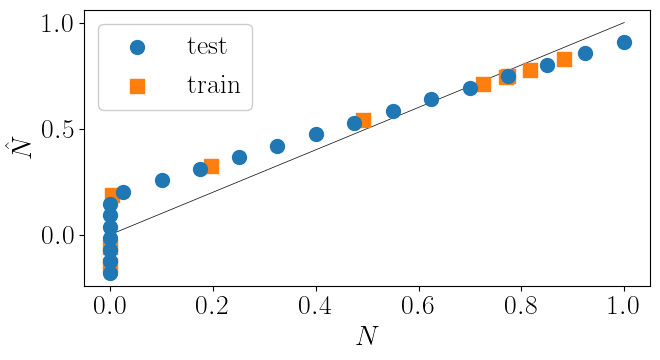

/tmp/ipykernel_91991/2940386462.py:18: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(labels_test, disps_test_1/expecs_der_test_1**2, s=100, marker="o", color="C0", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"


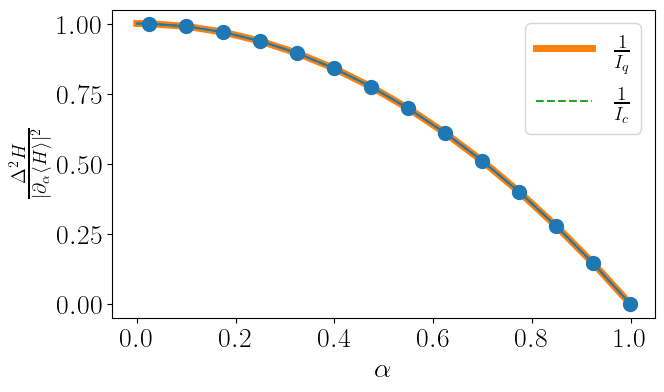

In [29]:
print()
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies_1, n_meas_1, n_layers_1))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))
sum_error_1 = sum(np.abs(labels_test - expecs_test_1)**2)/n_test
print("Sum error:", sum_error_1)

plt.figure(figsize=(7, 4))
plt.plot([0, 1], [0, 1], color="black", linewidth=0.5)
plt.scatter(labels_test, expecs_test_1, s=100, label=r"test", zorder=4) # , color="tab:cyan"
plt.scatter(labels_train, expecs_train_1, marker="s", s=100, label=r"train", zorder=3) # , color="tab:cyan"
plt.ylabel(r"$\hat{N}$" )
plt.xlabel(r"$N$")
plt.legend(framealpha=1)#
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(labels_test, disps_test_1/expecs_der_test_1**2, s=100, marker="o", color="C0", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
# plt.scatter(labels_test, disps_test, marker="x", s=100, color="C3", label=r"$\Delta^2 H$", zorder=4)
plt.plot(labels_test, 1/QFIs_test_1, color="C1", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.plot(labels_test, 1/CFIs_test_1, color="C2", label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"
plt.plot(labels_test, [1 - N**2 for N in labels_test])
plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_\alpha \langle H \rangle |^2}$")
plt.xlabel(r"$\alpha$")
plt.legend()
plt.show()

### 2 copies

In [30]:
n_copies_2 = 2
n_layers_2 = 2
n_tot_2 = n_inp*n_copies_2
n_meas_2 = n_inp*n_copies_2

# x0_2 = prev_to_next_ansatz(pars_1, n_tot_1, n_meas_1, n_layers_1, n_tot_2, n_meas_2, n_layers_2, subsval=pi)
# x0_2 = concatenate([normal(pi/2, 0.1, 3*n_layers_2*n_tot_2 - n_layers_2 + 2*n_tot_2), normal(0., 1e-3, 2**n_meas_2)])
x0_2 = concatenate([uniform(0, 2*pi, 3*n_layers_2*n_tot_2 - n_layers_2 + 2*n_tot_2), uniform(-0.5, 0.5, 2**n_meas_2)]) # 2*n_tot*(n_layers + 1))
# x0 = array(pars)
# x0 = None

time_start_2 = time()
fvals_2, result_2 = train(dms_train, labels_train, n_layers_2, method=method, n_copies=n_copies_2, n_meas=n_meas_2,
                      w_ls=w_ls, w_var=w_var, options=options, x0=x0_2)
time_finish_2 = time() - time_start_2
print("\n\nFinished in", time_finish_2)
print("Cost:", result_2.fun)
print(result_2.message)
pars_2 = result_2.x

expecs_train_2, expecs_der_train_2, disps_train_2, CFIs_train_2, QFIs_train_2 = aux_info_iso(pars_2, n_layers_2, labels_train, ps_train, n_copies=n_copies_2, n_meas=n_meas_2, dN=dN)
expecs_test_2, expecs_der_test_2, disps_test_2, CFIs_test_2, QFIs_test_2 = aux_info_iso(pars_2, n_layers_2, labels_test, ps_test, n_copies=n_copies_2, n_meas=n_meas_2, dN=dN)

			Iteration: 910 | Cost: 0.01126071 | Time passed: 15 s

Finished in 15.482656717300415
Cost: 0.011260714037849614
Optimization terminated successfully.


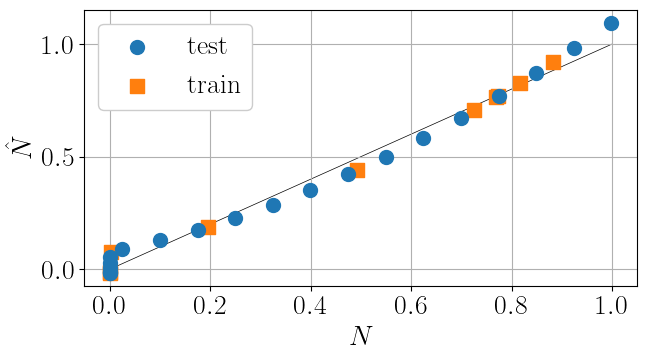

/tmp/ipykernel_91991/3084076881.py:19: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(labels_test, n_copies_2*disps_test_2/expecs_der_test_2**2, label=r"$m=2$", s=100, marker="s", color="C1", zorder=9) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"


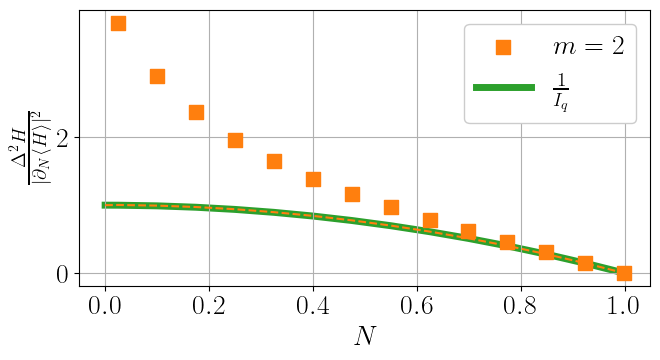

In [35]:
matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7, 4))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_2, s=100, label=r"test", zorder=4) # , color="tab:cyan"
plt.scatter(labels_train, expecs_train_2, marker="s", s=100, label=r"train", zorder=3) # , color="tab:cyan"
plt.plot([0, 1], [0, 1], color="black", linewidth=0.5, zorder=-1)
plt.ylabel(r"$\hat{N}$" )
plt.xlabel(r"$N$")
plt.legend(framealpha=1)#
plt.tight_layout()
plt.grid()
# plt.savefig("iso-est-m-test.pdf", transparent=True, bbox_inches='tight')
plt.show()


plt.figure(figsize=(7, 4))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, n_copies_2*disps_test_2/expecs_der_test_2**2, label=r"$m=2$", s=100, marker="s", color="C1", zorder=9) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
plt.plot(labels_test, n_copies_2/CFIs_test_2, color="C1", linewidth=1.5, linestyle="--", zorder=7) # , label=r"$\frac{1}{I_c}$"
plt.plot(labels_test, n_copies_2/QFIs_test_2, color="C2", linewidth=5, linestyle="solid", zorder=0, label=r"$\frac{1}{I_q}$") # 
# plt.plot(labels_test, [2 - N - N**2 for N in labels_test], color="C0", linewidth=1.5, linestyle="--", zorder=7)
# plt.plot(labels_test, [1 - N**2 for N in labels_test], color="C1", linewidth=1.5, linestyle="--", zorder=8)
plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_N \langle H \rangle |^2}$")
plt.xlabel(r"$N$")
plt.legend(framealpha=1)
plt.grid()
# plt.ylim(-0.05, 2.15)
plt.tight_layout()
# plt.savefig("iso-var_red-m-test.pdf", transparent=True, bbox_inches='tight')
plt.show()

### 3 copies

In [32]:
n_copies_3 = 3
n_layers_3 = 2
n_tot_3 = n_inp*n_copies_3
n_meas_3 = n_inp*n_copies_3

# x0_3 = prev_to_next_ansatz(pars_2, n_tot_2, n_meas_2, n_layers_2, n_tot_3, n_meas_3, n_layers_3, subsval=0)
# x0_3 = concatenate([normal(pi/2, 0.1, 3*n_layers_3*n_tot_3 - n_layers_3 + 2*n_tot_3), normal(0., 1e-3, 2**n_meas_3)])
x0_3 = concatenate([uniform(0, 2*pi, 3*n_layers_3*n_tot_3 - n_layers_3 + 2*n_tot_3), uniform(-0.5, 0.5, 2**n_meas_3)]) # 2*n_tot*(n_layers + 1))
# x0 = array(pars)
# x0 = None

time_start_3 = time()
fvals_3, result_3 = train(dms_train, labels_train, n_layers_3, method=method, n_copies=n_copies_3, n_meas=n_meas_3,
                      w_ls=w_ls, w_var=w_var, options=options, x0=x0_3)
time_finish_3 = time() - time_start_3
print("\n\nFinished in", time_finish_3)
print("Cost:", result_3.fun)
print(result_3.message)
pars_3 = result_3.x

expecs_train_3, expecs_der_train_3, disps_train_3, CFIs_train_3, QFIs_train_3 = aux_info_iso(pars_3, n_layers_3, labels_train, ps_train, n_copies=n_copies_3, n_meas=n_meas_3, dN=dN)
expecs_test_3, expecs_der_test_3, disps_test_3, CFIs_test_3, QFIs_test_3 = aux_info_iso(pars_3, n_layers_3, labels_test, ps_test, n_copies=n_copies_3, n_meas=n_meas_3, dN=dN)

			Iteration: 1459 | Cost: 0.00335403 | Time passed: 264 s

Finished in 264.64644622802734
Cost: 0.003354026485799384
Optimization terminated successfully.



n_inp: 2 | n_copies: 3 | n_meas: 6 | n_layers: 2 
w_ls: 1.000000 | w_var: 0.000100 
Sum error: 0.0005028476523508603


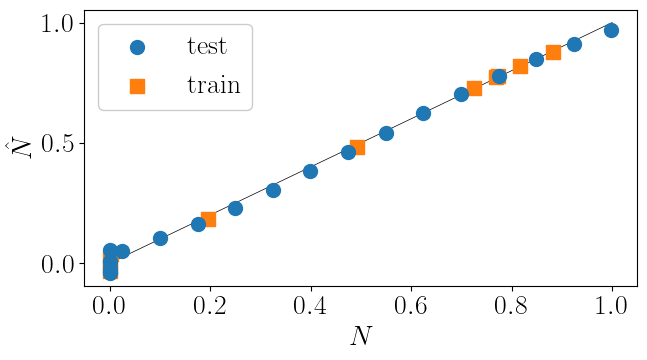

/tmp/ipykernel_91991/2809269846.py:18: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(labels_test, n_copies_3*disps_test_3/expecs_der_test_3**2, s=100, marker="o", color="C0", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"


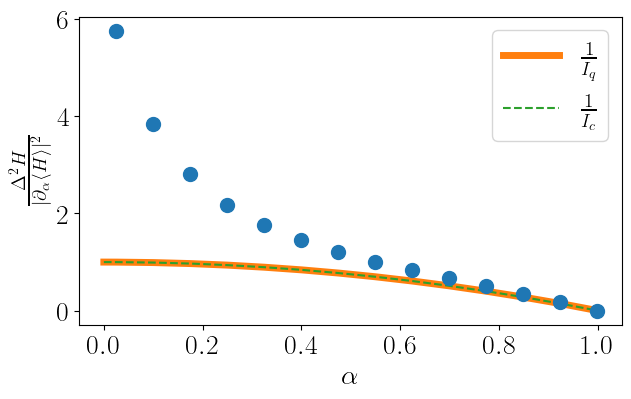

In [34]:
print()
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies_3, n_meas_3, n_layers_3))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))
sum_error_3 = sum(np.abs(labels_test - expecs_test_3)**2)/n_test
print("Sum error:", sum_error_3)

plt.figure(figsize=(7, 4))
plt.plot([0, 1], [0, 1], color="black", linewidth=0.5)
plt.scatter(labels_test, expecs_test_3, s=100, label=r"test", zorder=4) # , color="tab:cyan"
plt.scatter(labels_train, expecs_train_3, marker="s", s=100, label=r"train", zorder=3) # , color="tab:cyan"
plt.ylabel(r"$\hat{N}$" )
plt.xlabel(r"$N$")
plt.legend(framealpha=1)#
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(labels_test, n_copies_3*disps_test_3/expecs_der_test_3**2, s=100, marker="o", color="C0", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
plt.plot(labels_test, n_copies_3/QFIs_test_3, color="C1", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.plot(labels_test, n_copies_3/CFIs_test_3, color="C2", label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"

plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_\alpha \langle H \rangle |^2}$")
plt.xlabel(r"$\alpha$")
plt.legend()
plt.show()

### 4 copies

In [36]:
n_copies_4 = 4
n_layers_4 = 2
n_tot_4 = n_inp*n_copies_4
n_meas_4 = n_inp*n_copies_4

# x0_4 = prev_to_next_ansatz(pars_3, n_tot_3, n_meas_3, n_layers_3, n_tot_4, n_meas_4, n_layers_4, subsval=0)
# x0_4 = concatenate([normal(pi/4, 0.1, 3*n_layers_4*n_tot_4 - n_layers_4 + 2*n_tot_4), normal(0., 1e-3, 2**n_meas_4)])
# x0_4 = concatenate([uniform(0, 2*pi, 3*n_layers_4*n_tot_4 - n_layers_4 + 2*n_tot_4), uniform(-1, 1, 2**n_meas_4)]) # 2*n_tot*(n_layers + 1))
# x0 = array(pars)
x0 = None

# time_start_4 = time()
# fvals_4, result_4 = train(dms_train, labels_train, n_layers_4, method=method, n_copies=n_copies_4, n_meas=n_meas_4,
#                           # w_ls=w_ls, w_var=w_var, options=options, x0=x0_4, fvals=[])
#                           w_ls=w_ls, w_var=w_var, options=options, x0=pars_4, fvals=fvals_4)
# time_finish_4 = time() - time_start_4
# print("\n\nFinished in", time_finish_4)
# print("Cost:", result_4.fun)
# print(result_4.message)
# pars_4 = result_4.x

In [37]:
pars_4 = array([ 8.50041382e-01,  1.53615908e+00,  2.28498256e+00,  2.43618212e+00,
        1.15249707e+00,  8.13768951e-01, -2.26133624e-01,  1.53729901e-02,
        1.89547940e-01,  8.22077208e-01,  3.48231606e-01, -1.56939430e+00,
        8.23866293e-03, -2.05448641e-01,  7.76396088e-01,  7.32246305e-02,
        1.54559893e+00,  3.40823807e+00,  1.53254584e-01,  3.16575139e-02,
        2.70960860e-02, -2.91928211e-03,  2.75703059e+00, -7.33314100e-01,
        2.80133069e+00, -3.62656684e-02,  1.50873275e-02,  1.60993440e+00,
        1.55378702e+00,  6.44437810e-01, -2.31560532e-02,  4.86703395e-03,
       -1.77312210e+00,  5.56344104e-01,  1.71268960e+00,  2.39544771e+00,
        2.60605280e+00,  1.63869572e+00,  1.38570174e+00, -2.21445839e-01,
       -2.38881512e-01,  1.62895191e+00, -1.57114051e+00,  1.57804346e+00,
        1.56060519e+00,  1.55962090e+00,  1.50050203e+00,  1.34623205e+00,
        1.60209824e+00,  1.46191001e+00,  7.88106662e-01,  2.24858137e+00,
        1.55596602e+00, -1.05099832e+00, -7.91229422e-01, -2.20098924e+00,
       -2.50552210e-03,  1.77483223e+00,  7.58584460e-01,  2.54317250e-01,
        4.46540243e-03,  7.29269286e-01, -4.79880063e-01,  7.31007823e-01,
        6.88259812e-01,  7.44068859e-01, -3.64559545e-01, -3.95813430e-01,
       -1.67737611e-01, -3.53968876e-01, -4.23965976e-01,  5.80556894e-01,
        5.67165778e-01,  5.75823350e-01,  6.81783256e-01,  7.15003610e-01,
        6.57181951e-01, -4.92909838e-01, -5.65296053e-01,  5.28817068e-01,
        5.33298361e-01,  5.11127385e-01,  5.45949597e-01,  5.37464567e-01,
        5.47333742e-01, -5.07745117e-01, -9.19944139e-02, -5.52099533e-01,
       -5.80710768e-01, -5.55989524e-01,  5.41697219e-01,  5.06475244e-01,
        5.66334485e-01, -5.10165228e-01, -5.24671443e-01,  6.64444225e-01,
        6.54239885e-01,  6.58980164e-01, -5.21167822e-01, -5.42717148e-01,
       -5.09087750e-01, -3.39662655e-01, -4.10447149e-01,  6.39688246e-01,
        6.08084010e-01,  6.17691589e-01,  6.64424253e-01,  6.53946288e-01,
        6.50688699e-01, -4.94823065e-01, -3.63867468e-01, -4.13154037e-01,
       -3.90158709e-01, -4.38937098e-01, -3.74571604e-01, -3.90510264e-01,
       -2.72580061e-01, -3.81588202e-01,  6.89080132e-01, -3.60537900e-01,
       -3.64001662e-01, -3.40540222e-01, -4.36803811e-01, -3.43371951e-01,
       -3.49383357e-01, -3.75543541e-01, -3.18865009e-01,  8.60443045e-01,
        8.51555761e-01,  8.68578951e-01, -2.71948454e-01, -2.70376461e-01,
       -2.53382525e-01, -4.90235418e-01, -3.38746341e-01,  7.74902845e-01,
        7.64911162e-01,  7.79594016e-01,  8.61849791e-01,  9.08944588e-01,
        8.43437081e-01, -3.05444872e-01, -3.62501186e-01,  7.23935684e-01,
        7.36189474e-01,  6.88160379e-01,  7.29419849e-01,  7.00268312e-01,
        7.62031203e-01, -2.47451639e-01, -4.25539846e-01, -3.24929964e-01,
       -3.57302485e-01, -3.38237068e-01,  6.76829776e-01,  6.88179516e-01,
        7.04597207e-01, -3.26433354e-01, -3.06728987e-01,  8.47597060e-01,
        8.44706188e-01,  8.44597301e-01, -2.87599965e-01, -2.90329091e-01,
       -3.20098854e-01, -5.09371368e-01, -3.33885130e-01,  8.24586942e-01,
        8.13637777e-01,  8.15974365e-01,  8.54409371e-01,  8.62327818e-01,
        8.25760713e-01, -2.80306656e-01, -5.35753968e-01, -2.16075770e-01,
       -2.13806257e-01, -2.19695541e-01, -1.97515199e-01, -1.99089003e-01,
       -2.09184788e-01, -5.20753135e-01,  7.13396225e-01, -5.31714898e-01,
       -5.37377536e-01, -5.18741683e-01, -2.15048515e-01, -2.16507731e-01,
       -2.67184076e-01, -5.45483475e-01, -3.99549165e-01,  8.04813214e-01,
        7.93476853e-01,  8.06113758e-01, -3.48315142e-01, -3.60612994e-01,
       -3.39809991e-01, -4.68737188e-01, -2.64920007e-01,  7.84416332e-01,
        7.60294978e-01,  7.97945772e-01,  8.21882364e-01,  9.07229441e-01,
        8.22419134e-01, -3.66320923e-01, -3.70118870e-01,  6.80882194e-01,
        6.87379109e-01,  6.50707187e-01,  6.94596005e-01,  6.66024941e-01,
        7.74638947e-01, -2.51541569e-01, -3.33917596e-01, -3.59565599e-01,
                -3.93499590e-01, -3.61204632e-01,  6.35197355e-01,  6.74770074e-01,
        6.80562642e-01, -3.59901833e-01, -3.70033113e-01,  8.15882767e-01,
        8.09116499e-01,  8.11550011e-01, -3.45900647e-01, -3.57533292e-01,
       -3.32432243e-01, -4.88806048e-01, -4.02660333e-01,  7.39126681e-01,
        7.35063016e-01,  7.25374096e-01,  7.94987008e-01,  8.02472576e-01,
        7.54299785e-01, -3.62157982e-01, -5.21308622e-01, -2.76174618e-01,
       -2.74241395e-01, -2.80768569e-01, -2.78521045e-01, -2.82066466e-01,
       -3.08048363e-01, -5.04349832e-01,  7.24558912e-01, -5.13826372e-01,
       -5.19347185e-01, -5.01367704e-01, -2.72053996e-01, -2.26902746e-01,
       -3.04643789e-01, -5.30003068e-01, -5.10237739e-01, -9.28186886e-02,
       -9.42052377e-02, -9.28448015e-02, -4.93228010e-01, -5.03244086e-01,
       -5.00590256e-01,  7.00724013e-01, -4.91040283e-01, -1.32225263e-01,
       -1.51881097e-01, -1.21408554e-01, -9.01637214e-02, -3.35548232e-02,
       -1.03163299e-01, -5.07009258e-01, -4.76399542e-01, -1.78036957e-01,
       -1.68166867e-01, -2.13706072e-01, -8.54535795e-02, -1.01502541e-01,
        1.00635815e-01, -4.56346157e-01,  7.34062750e-01, -4.86635552e-01,
       -4.85139030e-01, -4.47182600e-01, -1.51870074e-01, -1.03614442e-01,
        3.15031391e-02, -4.86888998e-01, -4.64800812e-01, -5.37406062e-02,
       -7.15703478e-02, -4.29088243e-02, -4.91141748e-01, -4.97574177e-01,
       -4.85106504e-01,  6.96776304e-01, -4.37658767e-01, -1.58616542e-01,
       -1.67788776e-01, -1.72488246e-01, -8.48341589e-02, -8.24746424e-02,
       -1.08817641e-01, -4.90796081e-01,  6.91120788e-01, -5.06089637e-01,
       -5.03353600e-01, -4.92570248e-01, -4.84551414e-01, -4.93054939e-01,
       -4.94710574e-01,  6.96019594e-01,  9.46263511e-01,  7.16861597e-01,
        7.19691639e-01,  7.27250790e-01, -4.56950710e-01, -4.56661928e-01,
       -4.93555913e-01,  7.00905278e-01])

In [38]:
expecs_train_4, expecs_der_train_4, disps_train_4, CFIs_train_4, QFIs_train_4 = aux_info_iso(pars_4, n_layers_4, labels_train, ps_train, n_copies=n_copies_4, n_meas=n_meas_4, dN=dN)
expecs_test_4, expecs_der_test_4, disps_test_4, CFIs_test_4, QFIs_test_4 = aux_info_iso(pars_4, n_layers_4, labels_test, ps_test, n_copies=n_copies_4, n_meas=n_meas_4, dN=dN)


n_inp: 2 | n_copies: 4 | n_meas: 8 | n_layers: 2 
w_ls: 1.000000 | w_var: 0.000100 
Sum error: 0.0005360940089079337


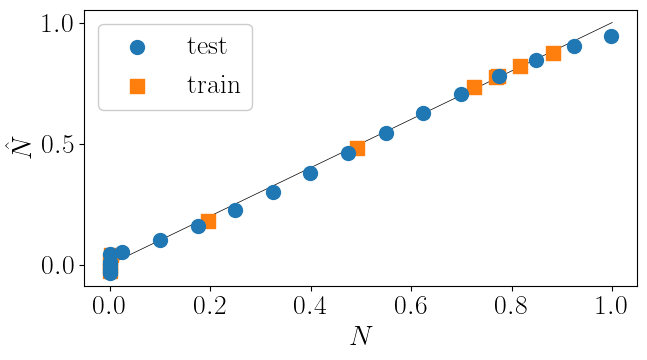

/tmp/ipykernel_91991/3315583939.py:18: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(labels_test, n_copies_4*disps_test_4/expecs_der_test_4**2, s=100, marker="o", color="C0", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"


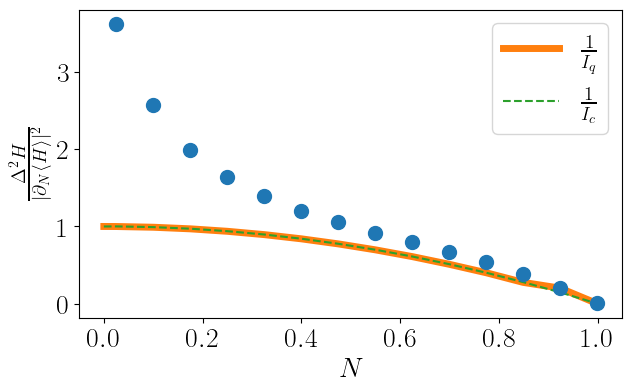

In [39]:
print()
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies_4, n_meas_4, n_layers_4))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))
sum_error_4 = sum(np.abs(labels_test - expecs_test_4)**2)/n_test
print("Sum error:", sum_error_4)

plt.figure(figsize=(7, 4))
plt.plot([0, 1], [0, 1], color="black", linewidth=0.5)
plt.scatter(labels_test, expecs_test_4, s=100, label=r"test", zorder=4) # , color="tab:cyan"
plt.scatter(labels_train, expecs_train_4, marker="s", s=100, label=r"train", zorder=3) # , color="tab:cyan"
plt.ylabel(r"$\hat{N}$" )
plt.xlabel(r"$N$")
plt.legend(framealpha=1)#
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(labels_test, n_copies_4*disps_test_4/expecs_der_test_4**2, s=100, marker="o", color="C0", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
plt.plot(labels_test, n_copies_4*1/QFIs_test_4, color="C1", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.plot(labels_test, n_copies_4*1/CFIs_test_4, color="C2", label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"
plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_N \langle H \rangle |^2}$")
plt.xlabel(r"$N$")
plt.legend()
# plt.yscale("log")
plt.show()

In [40]:
save_path = r"/home/kardashin/Work/QPE/Results/Entanglement/Negativity/"

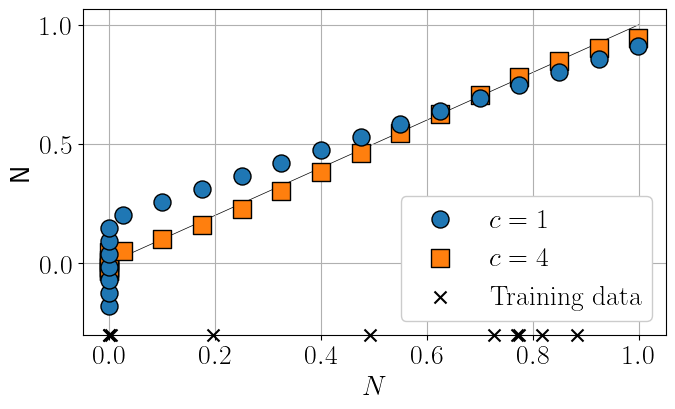

/tmp/ipykernel_91991/3441017793.py:22: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(labels_test, disps_test_1/expecs_der_test_1**2, s=150, marker="o", zorder=10, ec="black") # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
/tmp/ipykernel_91991/3441017793.py:25: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(labels_test, n_copies_4*disps_test_4/expecs_der_test_4**2, s=180, marker="s", zorder=9, ec="black") # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"


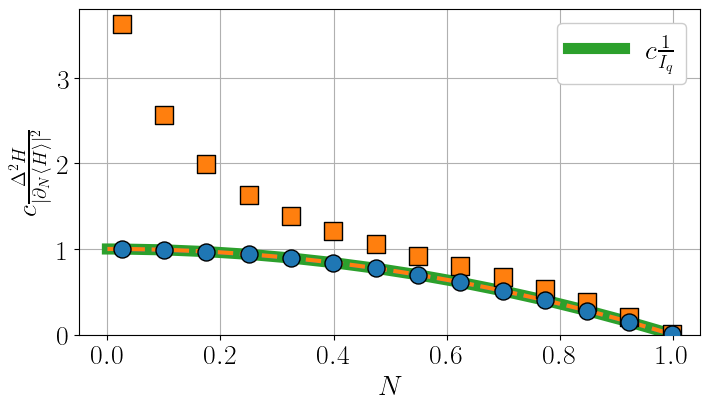

In [41]:
matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7.5, 4.5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_1, marker='o', s=150, label=r"$c=1$", zorder=10, ec="black")#, $E={}$".format(sum_error_1))
# plt.scatter(labels_test, expecs_test_2, marker='^', s=100, label=r"$c=2$")#, $E={}$".format(sum_error_2))
# plt.scatter(labels_test, expecs_test_3, marker='x', s=100, label=r"$c=3$")#, $E={}$".format(sum_error_3))
plt.scatter(labels_test, expecs_test_4, marker='s', s=180, label=r"$c=4$", zorder=9, ec="black")#, $E={}$".format(sum_error_4))
plt.plot([0, 1], [0, 1], color="black", linewidth=0.5, zorder=-1)
plt.scatter(labels_train, [-0.3]*n_train, color="black", s=75, marker="x", clip_on=False, zorder=10, label="Training data") # 
plt.ylabel(r"$\mathsf{N}$" )
plt.xlabel(r"$N$")
plt.ylim(ymin=-0.3)
plt.legend(framealpha=1, loc=4)#
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + "iso-c-est-test.pdf", transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7.5, 4.5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, disps_test_1/expecs_der_test_1**2, s=150, marker="o", zorder=10, ec="black") # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
# plt.scatter(labels_test, n_copies_2*disps_test_2/expecs_der_test_2**2, s=100, marker="^", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
# plt.scatter(labels_test, n_copies_3*disps_test_3/expecs_der_test_3**2, s=100, marker="x", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
plt.scatter(labels_test, n_copies_4*disps_test_4/expecs_der_test_4**2, s=180, marker="s", zorder=9, ec="black") # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
# plt.plot(labels_test, n_copies_4*1/QFIs_test_4, color="C1", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.plot(labels_test, array([(1 - N**2) for N in labels_test]), color="C2", linewidth=8, linestyle="solid", label=r"$c\frac{1}{I_q}$") # , color="tab:blue", label=r"$c\frac{1}{I_q}$"
plt.plot(labels_test, n_copies_1*1/CFIs_test_1, color="C0", linewidth=3, linestyle="dashed", zorder=7) # , color="tab:red", label=r"$c\frac{1}{I_c}$"
plt.plot(labels_test, n_copies_4*1/CFIs_test_4, color="C1", linewidth=3, linestyle="dashed", zorder=7) # , color="tab:red", label=r"$c\frac{1}{I_c}$"
plt.ylabel(r"$c\frac{\Delta^2 H}{|\partial_N \langle H \rangle |^2}$")
plt.xlabel(r"$N$")
plt.ylim(ymin=0)
plt.legend(ncol=1, framealpha=1)
plt.grid()
# plt.yscale("log")
plt.tight_layout()
# plt.savefig(save_path + "iso-c-var-test.pdf", transparent=True, bbox_inches='tight')
plt.show()

# Different number of measured qubits, extension

In [3]:
def train_naimark(dms, labels, n_layers, n_copies=1, n_ext=1, method="BFGS", w_ls=1e0, w_var=1e-4, x0=None, options={}, save_data=False, file_name=None):

    n_inp = int(log2(len(dms[0])))
    n_tot = n_inp*n_copies + n_ext
    d_prim =  2**(n_inp*n_copies)

    n_pars_est = 2**n_ext
    n_pars_ans = (3*n_tot - 1)*n_layers + 2*n_tot # cry  
            
    dms_cop = [reduce(kron, [dm]*n_copies + [P0]*n_ext) for dm in dms]

    fvals = []
    fval_cont = [0]
    def fun(x):
        x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
        ansatz = hea_cry_rzrx(n_tot, n_layers, x_ans)
        # obs_u = ansatz.conj().T@kron_A_N(diag(x_est), d_prim)@ansatz
        obs_u = ansatz.conj().T@kron_N_A(diag(x_est), d_prim)@ansatz
        obs_u_sq = obs_u@obs_u
        expecs = []
        disps = []
        for dm in dms_cop:
            expecs.append(trace(dm@obs_u).real)
            disps.append(trace(dm@obs_u_sq).real)
        f = w_ls*np.sum((array(expecs) - array(labels))**2)
        f += w_var*np.sum(array(disps) - array(expecs)**2)
        fval_cont[0] = f
        return f
    
    if save_data == True and file_name is None:
        file_name = "pars-c=%d-e=%d=l=%d-w_ls=%f-w_var=%f-n_train=%d" %(n_copies, n_ext, n_layers, w_ls, w_var, len(labels))
    
    def callback(x):
        fvals.append(fval_cont[0])
        print("Iteration: %d | Function value: %.8f" %(len(fvals), fval_cont[0]), end="\r")
        if save_data == True:
            np.save(file_name, x)
        return None
    
    if method in ["Nelder-Mead", "L-BFGS-B", "SLSQP", "TNC", "Powell", "COBYLA"]:
        bounds = [(0, pi)]*n_pars_ans + [(-10, 10)]*n_pars_est
    else:
        bounds = None
    if x0 is None:
        x0_ans = normal(pi, 0.01*pi, n_pars_ans)
        x0_est = normal(0, 0.01, n_pars_est)
        x0 = concatenate([x0_ans, x0_est])
    
    optimization_result = minimize(fun=fun, x0=x0, bounds=bounds, method=method, callback=callback, options=options) # "maxiter": int(1e10)
    
    return fvals, optimization_result

In [4]:
def dm_iso_p_gen(p):
    n_inp = 2 # generalize later some day
    d = 2**n_inp
    sv_bell = sum([kron(vec, vec) for vec in eye(int(d/2))])/sqrt(d/2)
    dm_bell = outer(sv_bell, sv_bell)
    return p*dm_bell + (1 - p)/4*eye(4)

def dm_iso_N_gen(N):
    n_inp = 2 # generalize later some day
    d = 2**n_inp
    sv_bell = sum([kron(vec, vec) for vec in eye(int(d/2))])/sqrt(d/2)
    dm_bell = outer(sv_bell, sv_bell)
    return (2*N + 1)/3*dm_bell + (1 - N)/6*eye(4)

1.4735717796984625e-15


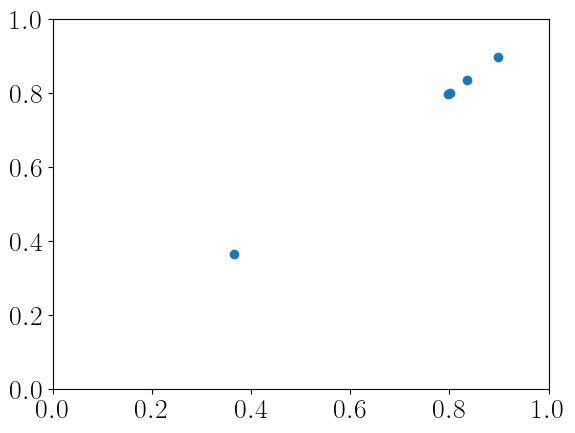

In [5]:
n_inp = 2
n_train = 5
n_test = 15
marks = "neg"

dm_bell = array([[1, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 1]])/2

ps_train = uniform(1/3 + 1e-5, 1 - 1e-5, n_train)
# ps_train = linspace(1/3 + 1e-3, 1 - 1e-3, n_train)
dms_train = [dm_iso_p_gen(p) for p in ps_train]
labels_train = [two_subsys_negativity(dm) for dm in dms_train]

ps_test = linspace(1/3 + 1e-3, 1 - 1e-3, n_test)
dms_test = [dm_iso_p_gen(p) for p in ps_test]
labels_test = [two_subsys_negativity(dm) for dm in dms_test]

dN = 1e-5
dms_train_check = []
QFIs = []
for N in labels_train:
    dm =   dm_iso_N_gen(N)
    dm_p = dm_iso_N_gen(N + dN)
    dm_m = dm_iso_N_gen(N - dN)
    QFI = 2*(1 - sqrt(fidelity(dm_m, dm_p))) / dN**2 + 1e-10 # via centered differences
    QFIs.append(QFI)
    dms_train_check.append(dm)

plt.scatter(ps_train, ps_train)
plt.xlim(0, 1)
plt.ylim(0, 1)

print(norm(array(dms_train) - array(dms_train_check)))

In [6]:
w_ls = 1e0
w_var = 1e-4
method = "BFGS"
options = {"maxiter": int(3e3)}#, "maxfun": int(1e10)}##

In [7]:
n_copies = 1
n_tot = n_inp*n_copies

In [8]:
def aux_info_iso_naimark(pars, n_layers, labels, ps, n_copies=1, n_ext=1, dN=1e-5, n_inp=2):
    """ For the optimized variables theta and x,
    calculates the expectations expecs, their derivatives excepcs_der,
    their variances disps, and quantum and classical Fisher informations """

    n_tot = n_inp*n_copies + n_ext
            
    pars_ans = pars[:-2**n_ext]
    pars_est = pars[-2**n_ext:]
    
    ansatz = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    
    projs = [kron(eye(2**n_inp), diag(line)) for line in eye(2**n_ext)]
    projs_u = [ansatz.conj().T@proj@ansatz for proj in projs]
    
    expecs = []
    expecs_der = []
    disps = []
    CFIs = []
    QFIs = []
    for j in range(len(ps)): # take a density matrix from the training set
        p = ps[j]
        N = labels[j]
        if p > 1/3:
            dm = dm_iso_N_gen(N)
            dm_p = dm_iso_N_gen(N + dN)
            dm_m = dm_iso_N_gen(N - dN)
            
            dm = reduce(kron, [dm]*n_copies + [P0]*n_ext)
            dm_p = reduce(kron, [dm_p]*n_copies + [P0]*n_ext)
            dm_m = reduce(kron, [dm_m]*n_copies + [P0]*n_ext)
            
            probs = [trace(dm@proj).real for proj in projs_u]
            probs_der = [trace((dm_p - dm_m)@proj).real/(2*dN) for proj in projs_u]
            
            expec = sum([out_i*prob_i for out_i, prob_i in zip(pars_est, probs)])
            expec_der = sum([out*prob_der for out, prob_der in zip(pars_est, probs_der)])
            disp = sum([out_i**2*prob_i for out_i, prob_i in zip(pars_est, probs)]) - expec**2
            
            CFI = sum([prob_der**2/prob if prob > 0 else 0 for prob_der, prob in zip(probs_der, probs)]) + 1e-10
            QFI = 2*(1 - sqrt(fidelity(dm_m, dm_p))) / dN**2 + 1e-10 # via centered differences 
            
            expecs.append(expec)
            expecs_der.append(expec_der)
            disps.append(disp)
            CFIs.append(CFI)
            QFIs.append(QFI)
            
        else:
            dm = dm_iso_p_gen(p)
            dm = reduce(kron, [dm_n]*n_copies + [P0]*n_ext)
            
            probs = [trace(dm@proj).real for proj in projs_u]
            probs_der = [0 for proj in projs_u]
            
            expec = sum([out_i*prob_i for out_i, prob_i in zip(pars_est, probs)])
            expec_der = sum([out*prob_der for out, prob_der in zip(pars_est, probs_der)])
            
            disp = sum([out_i**2*prob_i for out_i, prob_i in zip(pars_est, probs)]) - expec**2
            CFI = n_copies # placeholder; excluded from the plot
            QFI = n_copies # placeholder; excluded from the plot
            
            expecs.append(expec)
            expecs_der.append(expec_der)
            disps.append(disp)
            CFIs.append(CFI)
            QFIs.append(QFI)
    
    return array(expecs), array(expecs_der), array(disps), array(CFIs), array(QFIs)

### extension

Iteration: 870 | Function value: 0.00027393

Finished in 22.685113191604614
Cost: 0.0002739336329163137
Optimization terminated successfully.
n_inp: 2 | n_copies: 1 | n_meas: 1 | n_layers: 3 
w_ls: 1.000000 | w_var: 0.000100 
Sum error: 5.1137372732237685e-08


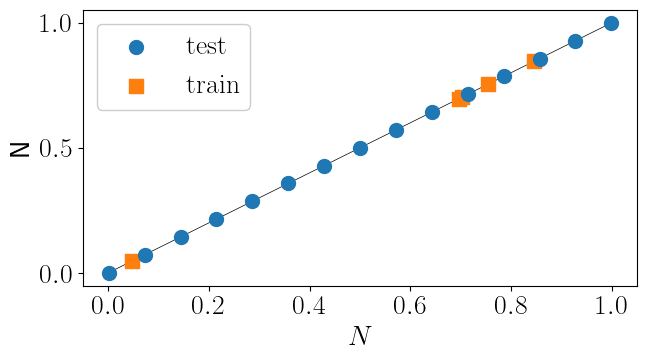

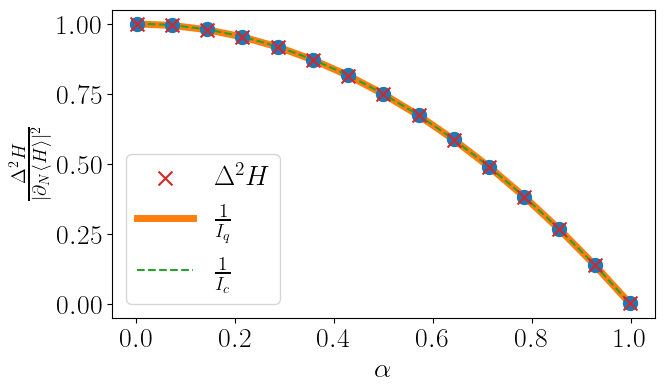

In [16]:
n_layers_ext = 3
n_ext = 1
n_tot_ext = n_inp*n_copies + n_ext

x0_ext = concatenate([uniform(0, 2*pi, 3*n_layers_ext*n_tot_ext - n_layers_ext + 2*n_tot_ext), uniform(-0.1, 0.1, 2**n_ext)]) # 2*n_tot*(n_layers + 1))

time_start_ext = time()
fvals_ext, result_ext = train_naimark(dms_train, labels_train, n_layers_ext, method=method, n_copies=n_copies, n_ext=n_ext,
                                      w_ls=w_ls, w_var=w_var, options=options, x0=x0_ext)
time_finish_ext = time() - time_start_ext
print("\n\nFinished in", time_finish_ext)
print("Cost:", result_ext.fun)
print(result_ext.message)
pars_ext = result_ext.x


expecs_train_ext, expecs_der_train_ext, disps_train_ext, CFIs_train_ext, QFIs_train_ext = aux_info_iso_naimark(pars_ext, n_layers_ext, labels_train, ps_train, n_copies=n_copies, n_ext=n_ext, dN=dN)
expecs_test_ext, expecs_der_test_ext, disps_test_ext, CFIs_test_ext, QFIs_test_ext = aux_info_iso_naimark(pars_ext, n_layers_ext, labels_test, ps_test, n_copies=n_copies, n_ext=n_ext, dN=dN)


print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies, n_ext, n_layers_ext))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))
sum_error_ext = sum(np.abs(labels_test - expecs_test_ext)**2)/n_test
print("Sum error:", sum_error_ext)

plt.figure(figsize=(7, 4))
plt.plot([0, 1], [0, 1], color="black", linewidth=0.5)
plt.scatter(labels_test, expecs_test_ext, s=100, label=r"test", zorder=4) # , color="tab:cyan"
plt.scatter(labels_train, expecs_train_ext, marker="s", s=100, label=r"train", zorder=3) # , color="tab:cyan"
plt.ylabel(r"$\mathsf{N}$" )
plt.xlabel(r"$N$")
plt.legend(framealpha=1)#
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(labels_test, disps_test_ext/expecs_der_test_ext**2, s=100, marker="o", color="C0", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
plt.scatter(labels_test, disps_test_ext, marker="x", s=100, color="C3", label=r"$\Delta^2 H$", zorder=4)
plt.plot(labels_test, 1/QFIs_test_ext, color="C1", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.plot(labels_test, 1/CFIs_test_ext, color="C2", label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"

plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_N \langle H \rangle |^2}$")
plt.xlabel(r"$\alpha$")
plt.legend()
plt.show()

In [19]:
expecs_ext = array([0.44444557, 0.45238183, 0.4603181 , 0.46825436, 0.47619063,
        0.48412689, 0.49206316, 0.49999942, 0.50793568, 0.51587195,
        0.52380821, 0.53174448, 0.53968074, 0.547617  , 0.55555327])
expecs_der_ext = array([0.11111103, 0.11111103, 0.11111103, 0.11111103, 0.11111103,
        0.11111103, 0.11111103, 0.11111103, 0.11111103, 0.11111103,
        0.11111103, 0.11111103, 0.11111103, 0.11111103, 0.11111103])
disps_ext = array([1.23456629e-02, 1.22826520e-02, 1.20936726e-02, 1.17787246e-02,
        1.13378080e-02, 1.07709229e-02, 1.00780691e-02, 9.25924682e-03,
        8.31445593e-03, 7.24369647e-03, 6.04696843e-03, 4.72427182e-03,
        3.27560663e-03, 1.70097287e-03, 3.70531543e-07])

### $m=1$

			Iteration: 46 | Cost: 0.00046882 | Time passed: 0 s

Finished in 0.1978321075439453
Cost: 0.0004688158336027722
Optimization terminated successfully.
n_inp: 2 | n_copies: 1 | n_meas: 1 | n_layers: 1 
w_ls: 1.000000 | w_var: 0.000100 
Sum error: 1.421581055858689e-07


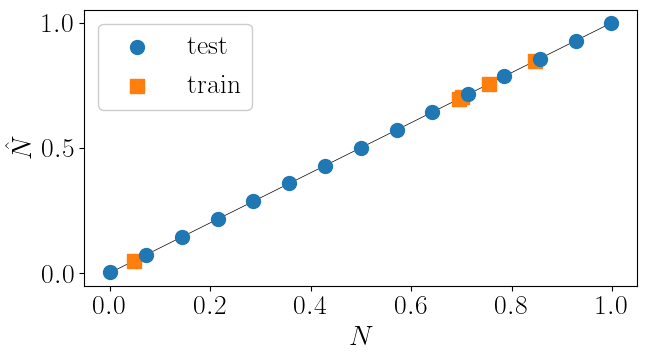

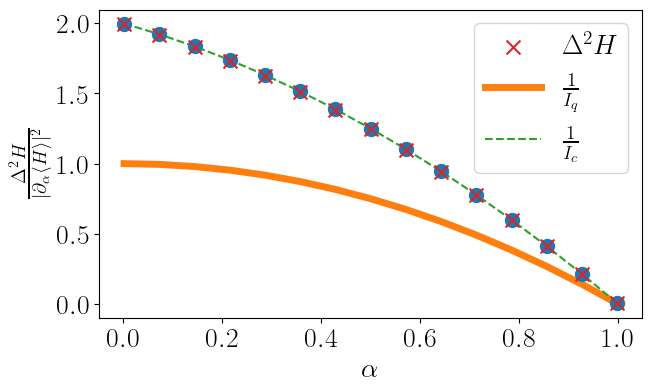

In [10]:
n_layers_1m = 1
n_meas_1m = 1

# x0_1m = prev_to_next_ansatz(pars_2, n_tot_2, n_meas_2, n_layers_2, n_tot_1m, n_meas_1m, n_layers_1m, subsval=0)
# x0_1m = concatenate([normal(pi/6, 1e-3, 3*n_layers_1m*n_tot - n_layers_1m + 2*n_tot), normal(0., 1e-3, 2**n_meas_1m)])
x0_1m = concatenate([uniform(0, 2*pi, 3*n_layers_1m*n_tot - n_layers_1m + 2*n_tot), uniform(-1, 1, 2**n_meas_1m)]) # 2*n_tot*(n_layers + 1))
# x0 = array(pars)
# x0 = None

time_start_1m = time()
fvals_1m, result_1m = train(dms_train, labels_train, n_layers_1m, method=method, n_copies=n_copies, n_meas=n_meas_1m,
                      w_ls=w_ls, w_var=w_var, options=options, x0=x0_1m)
time_finish_1m = time() - time_start_1m
print("\n\nFinished in", time_finish_1m)
print("Cost:", result_1m.fun)
print(result_1m.message)
pars_1m = result_1m.x

expecs_train_1m, expecs_der_train_1m, disps_train_1m, CFIs_train_1m, QFIs_train_1m = aux_info_iso(pars_1m, n_layers_1m, labels_train, ps_train, n_copies=n_copies, n_meas=n_meas_1m, dN=dN)
expecs_test_1m, expecs_der_test_1m, disps_test_1m, CFIs_test_1m, QFIs_test_1m = aux_info_iso(pars_1m, n_layers_1m, labels_test, ps_test, n_copies=n_copies, n_meas=n_meas_1m, dN=dN)

print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies, n_meas_1m, n_layers_1m))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))
sum_error_1m = sum(np.abs(labels_test - expecs_test_1m)**2)/n_test
print("Sum error:", sum_error_1m)

plt.figure(figsize=(7, 4))
plt.plot([0, 1], [0, 1], color="black", linewidth=0.5)
plt.scatter(labels_test, expecs_test_1m, s=100, label=r"test", zorder=4) # , color="tab:cyan"
plt.scatter(labels_train, expecs_train_1m, marker="s", s=100, label=r"train", zorder=3) # , color="tab:cyan"
plt.ylabel(r"$\hat{N}$" )
plt.xlabel(r"$N$")
plt.legend(framealpha=1)#
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(labels_test, disps_test_1m/expecs_der_test_1m**2, s=100, marker="o", color="C0", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
plt.scatter(labels_test, disps_test_1m, marker="x", s=100, color="C3", label=r"$\Delta^2 H$", zorder=4)
plt.plot(labels_test, 1/QFIs_test_1m, color="C1", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.plot(labels_test, 1/CFIs_test_1m, color="C2", label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"

plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_\alpha \langle H \rangle |^2}$")
plt.xlabel(r"$\alpha$")
plt.legend()
plt.show()

In [17]:
expecs_1 = array([0.46666926, 0.47143095, 0.47619265, 0.48095434, 0.48571603,
        0.49047772, 0.49523941, 0.5000011 , 0.50476279, 0.50952448,
        0.51428617, 0.51904786, 0.52380956, 0.52857125, 0.53333294])
expecs_der_1 = array([0.06666568, 0.06666568, 0.06666568, 0.06666568, 0.06666568,
        0.06666568, 0.06666568, 0.06666568, 0.06666568, 0.06666568,
        0.06666568, 0.06666568, 0.06666568, 0.06666568, 0.06666568])
disps_1 = array([8.88855779e-03, 8.54843322e-03, 8.16296124e-03, 7.73214186e-03,
        7.25597507e-03, 6.73446088e-03, 6.16759929e-03, 5.55539029e-03,
        4.89783389e-03, 4.19493008e-03, 3.44667887e-03, 2.65308026e-03,
        1.81413425e-03, 9.29840825e-04, 2.00000757e-07])

### $m=2$

			Iteration: 519 | Cost: 0.00027360 | Time passed: 1 s

Finished in 1.043370246887207
Cost: 0.00027360213043516675
Optimization terminated successfully.
n_inp: 2 | n_copies: 1 | n_meas: 2 | n_layers: 1 
w_ls: 1.000000 | w_var: 0.000100 
Sum error: 4.798712608220342e-08


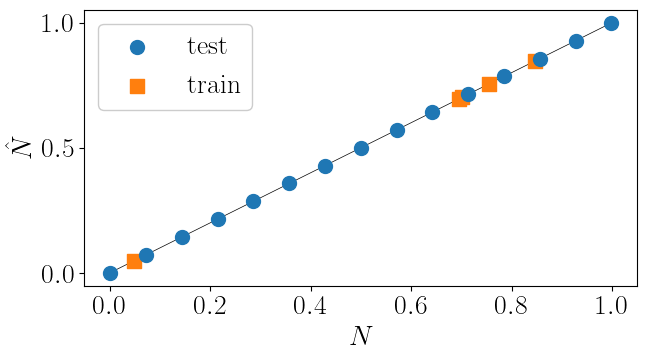

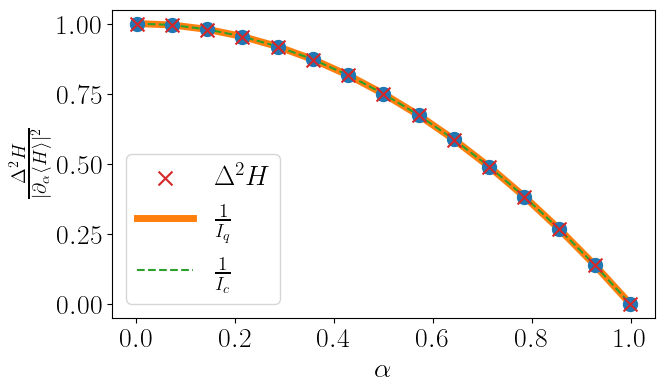

In [13]:
n_layers_2m = 1
n_meas_2m = 2

# x0_2m = prev_to_next_ansatz(pars_2, n_tot_2, n_meas_2, n_layers_2, n_tot_2m, n_meas_2m, n_layers_2m, subsval=0)
# x0_2m = concatenate([normal(pi/6, 1e-3, 3*n_layers_2m*n_tot - n_layers_2m + 2*n_tot), normal(0., 1e-3, 2**n_meas_2m)])
x0_2m = concatenate([uniform(0, 2*pi, 3*n_layers_2m*n_tot - n_layers_2m + 2*n_tot), uniform(-1, 1, 2**n_meas_2m)]) # 2*n_tot*(n_layers + 1))
# x0 = array(pars)
# x0 = None

time_start_2m = time()
fvals_2m, result_2m = train(dms_train, labels_train, n_layers_2m, method=method, n_copies=n_copies, n_meas=n_meas_2m,
                      w_ls=w_ls, w_var=w_var, options=options, x0=x0_2m)
time_finish_2m = time() - time_start_2m
print("\n\nFinished in", time_finish_2m)
print("Cost:", result_2m.fun)
print(result_2m.message)
pars_2m = result_2m.x

expecs_train_2m, expecs_der_train_2m, disps_train_2m, CFIs_train_2m, QFIs_train_2m = aux_info_iso(pars_2m, n_layers_2m, labels_train, ps_train, n_copies=n_copies, n_meas=n_meas_2m, dN=dN)
expecs_test_2m, expecs_der_test_2m, disps_test_2m, CFIs_test_2m, QFIs_test_2m = aux_info_iso(pars_2m, n_layers_2m, labels_test, ps_test, n_copies=n_copies, n_meas=n_meas_2m, dN=dN)

print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies, n_meas_2m, n_layers_2m))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))
sum_error_2m = sum(np.abs(labels_test - expecs_test_2m)**2)/n_test
print("Sum error:", sum_error_2m)

plt.figure(figsize=(7, 4))
plt.plot([0, 1], [0, 1], color="black", linewidth=0.5)
plt.scatter(labels_test, expecs_test_2m, s=100, label=r"test", zorder=4) # , color="tab:cyan"
plt.scatter(labels_train, expecs_train_2m, marker="s", s=100, label=r"train", zorder=3) # , color="tab:cyan"
plt.ylabel(r"$\hat{N}$" )
plt.xlabel(r"$N$")
plt.legend(framealpha=1)#
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(labels_test, disps_test_2m/expecs_der_test_2m**2, s=100, marker="o", color="C0", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
plt.scatter(labels_test, disps_test_2m, marker="x", s=100, color="C3", label=r"$\Delta^2 H$", zorder=4)
plt.plot(labels_test, 1/QFIs_test_2m, color="C1", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.plot(labels_test, 1/CFIs_test_2m, color="C2", label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"

plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_\alpha \langle H \rangle |^2}$")
plt.xlabel(r"$\alpha$")
plt.legend()
plt.show()

In [18]:
expecs_2 = array([0.44444179, 0.45237837, 0.46031495, 0.46825153, 0.47618811,
        0.48412469, 0.49206127, 0.49999785, 0.50793443, 0.51587101,
        0.52380759, 0.53174417, 0.53968075, 0.54761732, 0.5555539 ])
expecs_der_2 = array([0.11111545, 0.11111545, 0.11111545, 0.11111545, 0.11111545,
        0.11111545, 0.11111545, 0.11111545, 0.11111545, 0.11111545,
        0.11111545, 0.11111545, 0.11111545, 0.11111545, 0.11111545])
disps_2 = array([1.23466439e-02, 1.22836282e-02, 1.20946338e-02, 1.17796608e-02,
        1.13387092e-02, 1.07717791e-02, 1.00788703e-02, 9.25998291e-03,
        8.31511693e-03, 7.24427236e-03, 6.04744919e-03, 4.72464742e-03,
        3.27586706e-03, 1.70110809e-03, 3.70521727e-07])

### plots

In [14]:
save_path = r"/home/kardashin/Work/QPE/Results/Entanglement/Negativity/"

/tmp/ipykernel_91991/1156350051.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


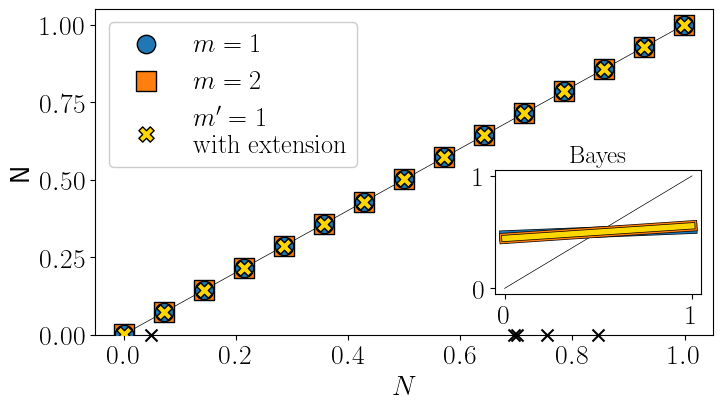

/tmp/ipykernel_91991/1156350051.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


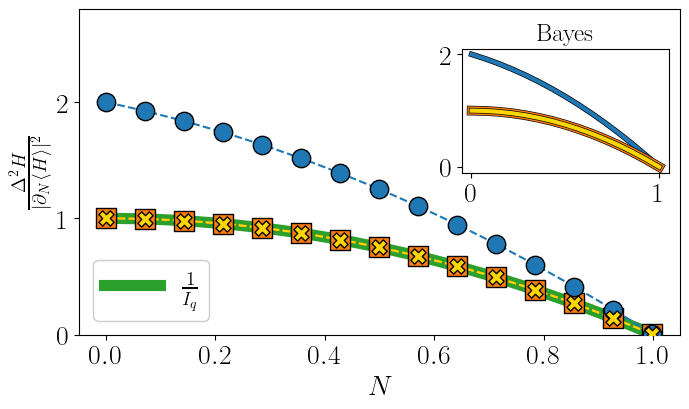

In [23]:
matplotlib.rcParams.update({'font.size': 20})


fig, ax1 = plt.subplots(figsize=(7.5, 4.5))
ax1.scatter(labels_test, expecs_test_1m, marker='o', s=175, label=r"$m=1$", zorder=10, ec="black")#, $E={}$".format(sum_error_1))
ax1.scatter(labels_test, expecs_test_2m, marker='s', s=200, label=r"$m=2$", zorder=8, ec="black")#, $E={}$".format(sum_error_4))
ax1.scatter(labels_test, expecs_test_ext, marker='X', color="gold", s=120, label=r"$m'=1$" +"\nwith extension", ec="black", zorder=11)#, $E={}$".format(sum_error_4))
ax1.plot([0, 1], [0, 1], color="black", linewidth=0.5, zorder=6)
ax1.scatter(labels_train, [0]*n_train, color="black", s=75, marker="x", clip_on=False, zorder=10) # 
ax1.set_ylabel(r"$\mathsf{N}$" )
ax1.set_xlabel(r"$N$")
ax1.set_ylim(ymin=0)
ax1.legend(framealpha=1, fontsize=19, ncol=1)#, bbox_to_anchor=(.475, 0.55))#
# ax1.grid(zorder=-1)
ax2 = fig.add_axes([0.67, 0.3, 0.275, 0.275])
# ax2 = fig.add_axes([0.615, 0.2, 0.275, 0.275])
ax2.plot([0, 1], [0, 1], color="black", linewidth=0.5)
ax2.plot(labels_test, expecs_1, color="black",        linewidth=8, alpha=1)
ax2.plot(labels_test, expecs_1, color="tab:blue",     linewidth=7, alpha=1)
ax2.plot(labels_test, expecs_2, color="black",        linewidth=8, alpha=1)
ax2.plot(labels_test, expecs_2, color="C1",           linewidth=7, alpha=1)
ax2.plot(labels_test, expecs_ext, color="black",      linewidth=5, alpha=1)
ax2.plot(labels_test, expecs_ext, color="gold", linewidth=4, alpha=1)
ax2.set_title("Bayes", fontsize=18)
ax2.patch.set_facecolor('white')
# ax2.patch.set_alpha(1)
plt.tight_layout()
plt.savefig(save_path + "iso-est-m-test-trunc-ext.pdf", transparent=False, bbox_inches='tight')
plt.show()

fig, ax1 = plt.subplots(figsize=(7.5, 4.5))
ax1.scatter(labels_test, disps_test_1m/expecs_der_test_1m**2, s=175, marker="o", color=None, ec="black", zorder=10) # , label=r"$m=1$"
ax1.scatter(labels_test, disps_test_2m/expecs_der_test_2m**2, s=200, marker="s", color="C1", ec="black", zorder=9) # , label=r"$m=2$"
ax1.scatter(labels_test, disps_test_ext/expecs_der_test_ext**2, s=120, marker="X", color="gold", ec="black", zorder=11) # , label=r"$m=1$ with extension"
ax1.plot(labels_test, 1/CFIs_test_1m, color="C0", linewidth=1.5, linestyle="--", zorder=8) # , label=r"$\frac{1}{I_c}$"
ax1.plot(labels_test, 1/CFIs_test_2m, color="C1", linewidth=1.5, linestyle="--", zorder=7) # , label=r"$\frac{1}{I_c}$"
ax1.plot(labels_test, 1/CFIs_test_2m, color="gold", linewidth=1.5, linestyle="--", zorder=7) # , label=r"$\frac{1}{I_c}$"
ax1.plot(labels_test, 1/QFIs_test_2m, color="C2", linewidth=8, linestyle="solid", zorder=1, label=r"$\frac{1}{I_q}$") # 
ax1.set_ylabel(r"$\frac{\Delta^2 H}{|\partial_N \langle H \rangle |^2}$")
ax1.set_xlabel(r"$N$")
ax1.set_ylim(ymin=0, ymax=2.8)
ax1.legend(framealpha=1, fontsize=20, loc=3)#, bbox_to_anchor=(1., 0.75))
# ax1.grid(zorder=-1)
ax2 = fig.add_axes([0.67, 0.57, 0.275, 0.275])
# ax2 = fig.add_axes([0.615, 0.515, 0.275, 0.275])
ax2.plot(labels_test, disps_1/expecs_der_1**2, color="black",          linewidth=4, alpha=1)
ax2.plot(labels_test, disps_1/expecs_der_1**2, color="tab:blue",       linewidth=3, alpha=1)
ax2.plot(labels_test, disps_2/expecs_der_2**2, color="black",          linewidth=7, alpha=1)
ax2.plot(labels_test, disps_2/expecs_der_2**2, color="C1",             linewidth=6, alpha=1)
ax2.plot(labels_test, disps_ext/expecs_der_ext**2, color="black",      linewidth=4, alpha=1)
ax2.plot(labels_test, disps_ext/expecs_der_ext**2, color="gold", linewidth=3, alpha=1)
ax2.set_title("Bayes", fontsize=18)
ax2.patch.set_facecolor('white')
# ax2.patch.set_alpha(1)
fig.tight_layout()
fig.savefig(save_path + "iso-var-m-test-trunc-ext.pdf", transparent=False, bbox_inches='tight')
plt.show()